In [92]:
#############################################################################################################
#Title: Boiler Feed Pump Performance Curve Model                                                            #
#Author: Chris Hui                                                                                          #
#Date: 29/9/2017                                                                                            #
#Version: 1.4                                                                                               # 
#Purpose: Currently the Muja Engineering team does not have visible access of Boiler Feed                   #
#pump performance. Due to the lack of visibility, engineers are not able to monitor pump                    #
#degradation and perform maintenance on the pumps on a scheduled maintenance perspective.                   #
#The development of the Boiler Feed Pump Curves is to enable the engineers to have a                        #
#continuous and real time view of our pump performance. With corrective maintenance                         #
#costs being up to $0.8M each year, if proactive maintenance could be carried out                           #
#this could result in sizeable savings.                                                                     #
#############################################################################################################

############################################################################################################
#List the libraries required for the Boiler Feed Pump Analysis                                             #
# We require the following libraries to be used:                                                            #
# numpy - This may be used for array transformations. Currently it is not in use.                          #
# seaborn - This is our visualisation package which will allow us to create aesthetically pleasing plots.  # 
# pandas - We have used pandas as our primary way of manipulating and storing the data we have extracted.  # 
# matplotlib - This is the default plotting engine that we have used for our basic plots.                  #
############################################################################################################
import numpy as np
import seaborn as sbn
import pandas as pd
import matplotlib.pyplot as plt
import math 
from scipy import stats, integrate
from matplotlib.ticker import MultipleLocator
from sklearn.preprocessing import scale

#############################################################################################################
#FUNCTIONS                                                                                                  # 
#We needed to define a custom function to show the R Squared Value for the Seaborn Library.                 #
#Seaborn in it's current release does not have a function to show the R Squared Values.                     # 
#Function Source: https://stackoverflow.com/questions/25579227/seaborn-implot-with-equation-and-r2-text     #                                                                                                      #
#############################################################################################################
def r2(x, y):
    return stats.pearsonr(x, y)[0] ** 2

In [93]:
################################################################################################
#IMPORT DATA and CLEANSE                                                                       #
#==============================================================================================#
#Source: BFP.csv                                                                               #  
#Logic: I was intending to write a script to connect to the PI Asset Hierarchy Database we     #
#have in the office. However, as this is intended to be reproducible for other people I have   #
#opted to use a .CSV file as in my initial input. For subsequent work versions I will create   #
#a wrapper which will allow Python to talk directly to the Plant Information (PI) System.      #
################################################################################################

file = pd.ExcelFile('BFP_Data.xlsx')
sheets = file.sheet_names
print(sheets)
#Get the sheet-name of interest which we want to look at. Store this inside sheets. 
#We will need both the raw_feeds tab and the efficiency_data_1w tab
df = file.parse('raw_feeds_1w', skiprows=1)
efficiency_df = file.parse('efficiency_data_1w', skiprows=1)

#Skip the initial first row as these are all PI Tags which are not meaningful (i.e. M5-BFP-ABC...)
#Create a list of names to replace the PI Tag names whcih are not meaningful
names =['Date', 'Flow_Rate_(KG/S)', 'BFP_N_Discharge_Pressure', 'BFP_N_Daerator_Shell_Pressure', 'Daerator_Height_Conv_Pressure', 'Specific_Gravity','Gravity','Sulzer_RPM', 'Pump_RPM']
names_eff = ['Date','Motor_Amps', 'Rated_Voltage', 'BFP_water_temperature','Power_Factor','Motor_Efficiency','Gravity_Acceleration','Steam_table_SG' ]
#Use .dropNA to remove all columns which contain NAN data
df.dropna(axis=1, how='all', inplace=True)
efficiency_df.dropna(axis=1, how='all', inplace=True)
#Replace column names with names list with list arguments stored in names and names_eff
df.columns = names
efficiency_df.columns = names_eff
#Join the 2 dataframes together into one dataframe using the 'date' as the common index. The type will be an outer join.
df.index = df.Date
efficiency_df.index = efficiency_df.Date

df = df.join(efficiency_df, how='outer', on='Date', lsuffix='_left', rsuffix='_right')
df.head()
####################################################################################################################################
#CALCULATION: Formula to calculate Total Head is below:                                                                                         #
#(Dp - Sp) / (Sg x G ) where Sp is calculated (Dh + Dsp) where Dh is calculated by applying the constant 9.804139432 to meters.   #
#This will then convert the Meters of the Daerator Head to an equivalent pressure (kPa)                                            #
#Dp = Discharge Pressure, Sp = Suction Pressure, Sg = Specific Gravity Constant (0.886001), G= Gravitational Constant (9.8)        #
#Dh is Daerator Height, Dsp is Daerator Shell Pressure                                                                             #
#                                                                                                                                  # 
#Suction Pressure will have to be created by adding the Daerator Shell Pressure with the Daerator Height                           #
#
#CALCULATION: Formula to calculate efficiency is below
#Efficiency = Net Output / Net Input
#Net Input is calculated via: SQUARE ROOT (3) * Motor Amps * Rated Voltage * Power Factor * Motor Efficiency
#Net Output is calculated via: (Specific Gravity * Gravity * Total Head * Discharge Flow Rate) / 1000
####################################################################################################################################
print (df.columns)
df['Suction Pressure']= df['BFP_N_Daerator_Shell_Pressure'].values + df['Daerator_Height_Conv_Pressure'].values
#With Suction Pressure now created we can calculate Total Head and add this as a column
df['Total Head'] = (df['BFP_N_Discharge_Pressure'].values - df['Suction Pressure'].values)/(df['Specific_Gravity'].values * df['Gravity'].values)

#Now that we have the Total Head, it is important that we compare the pump revolutions per minute against the target specification
#This is for the Sulzer Pump with a target specification of 6,412 RPMs
df['RPM_%'] = df['Pump_RPM'].values/df['Sulzer_RPM'].values

#Net Input Calculation Below
df['Net_Input'] = math.sqrt(3) * df['Motor_Amps'].values * df['Rated_Voltage'].values * df['Power_Factor'].values * df['Motor_Efficiency'].values  
df['Net_Output'] = (df['Specific_Gravity'].values * df['Gravity'].values * df['Total Head'].values * df['Flow_Rate_(KG/S)'].values)/1000
df['Efficiency_%'] = df['Net_Output'].values / df['Net_Input'].values

#Now we want to filter out data frame further with the following conditions
#If the flow rate is 0KG/S, Total Head is -ve AND RPM <=0, remove these from the dataframe
#If any of these conditions are met - we will remove the data from the dataframe as the pump is offline.
df = df[((df['Flow_Rate_(KG/S)']>0) & (df['Pump_RPM']>0) & (df['Total Head']>0))]



['raw_feeds_1w', 'efficiency_data_1w']
Index(['Date', 'Date_left', 'Flow_Rate_(KG/S)', 'BFP_N_Discharge_Pressure',
       'BFP_N_Daerator_Shell_Pressure', 'Daerator_Height_Conv_Pressure',
       'Specific_Gravity', 'Gravity', 'Sulzer_RPM', 'Pump_RPM', 'Date_right',
       'Motor_Amps', 'Rated_Voltage', 'BFP_water_temperature', 'Power_Factor',
       'Motor_Efficiency', 'Gravity_Acceleration', 'Steam_table_SG'],
      dtype='object')


       Flow_Rate_(KG/S)  BFP_N_Discharge_Pressure  \
count       1488.000000               1488.000000   
mean          64.274400              16521.629218   
std           13.984790               2554.890984   
min            5.280741                468.217013   
25%           54.253295              16535.108571   
50%           60.759293              17010.532994   
75%           73.890418              17443.735010   
max           96.726013              18937.967892   

       BFP_N_Daerator_Shell_Pressure  Daerator_Height_Conv_Pressure  \
count                    1488.000000                   1.488000e+03   
mean                      165.383957                   2.141006e+02   
std                        53.387407                   3.980377e-12   
min                        -0.868056                   2.141006e+02   
25%                       137.974973                   2.141006e+02   
50%                       142.821730                   2.141006e+02   
75%                      

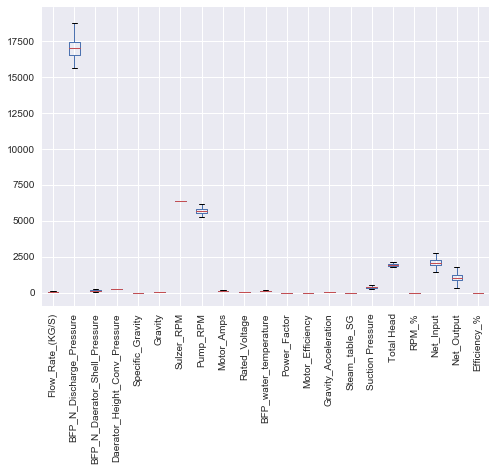

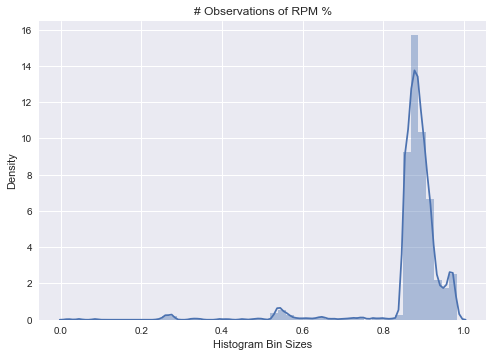

In [111]:
#########################################################################################################
#MODELLING THE DATA - Exploratory Data Analysis (EDA)                                                   #                            #
#-------------------------------------------------------------------------------------------------------#
#As a first pass performance measure, we need to plot Total Head (M) against Flow Rate (KG/S). This is  #
#not enough however to determine pump degradation. Our hypotheses is that motor efficiency is a key     # 
#indicator of performance degradation. There should be a relationship between Total Head and Efficiency.#
#The following steps will need to occur:                                                                # 
#1) Understand the shape of the data. Develop a histogram / KDE to identify the distribution of RPM%.   # 
#NOTE: Engineering target specifications indicate a curve should be fitted (theoretically) at 25%, 50%, #
#75% and 90%                                                                                            #
#2) Filter the dataframe (df) based off the historgram distribution.                                    #   
#3) Plot Total Head vs Flow Rate (Fit the points to a curve)                                            #
#4) Plot Efficiency Curve on a secondary axis with x = Flow Rate (KG/S)                                 # 
#########################################################################################################

#########################################################################################################
# Theoretical specifications of motor speed (RPM) indicate a pump curve of 25%,50%,75%,90% and 100%     # 
# should be fitted. The first question we need to address is: Is this valid?                            #
# To address this we want to understand the shape of our data. We have opted to use a KDE plot which    # 
# shows a CDF (X-axis) overlaid with a density function (Y-axis). From this we can see that the density #
# is highest at ~ 90%. Hence, it would not make sense for 25%, 50%, 75% or 100% curves to be fitted.    #
#########################################################################################################


#df.info()
#print (df.shape)
print (df.describe())
print (df.corr())
df.boxplot()
plt.xticks(rotation=90)
plt.show()

distPlot = sbn.distplot(df['RPM_%'].values, kde=True)
ax.set_ylim([0.0, 1.0])
ax.yaxis.set_major_locator(MultipleLocator(0.1))
plt.xlabel('Histogram Bin Sizes')
plt.ylabel('Density')
plt.title("# Observations of RPM %" )
plt.show()



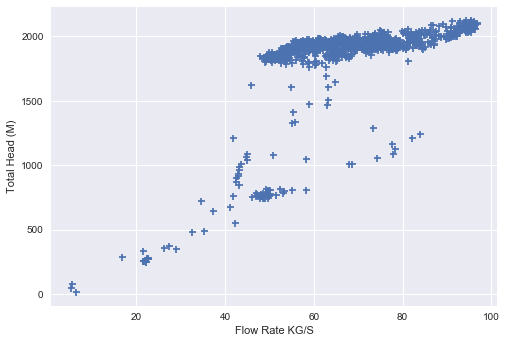

In [95]:
#########################################################################################################
# Further analysis of our dataset reveals Before we apply the 90% Filter to our dataset, it may be worthwhile plotting out the Fl     # 
# should be fitted. The first question we need to address is: Is this valid?                            #
# To address this we want to understand the shape of our data. We have opted to use a KDE plot which    # 
# shows a PDF (X-axis) overlaid with # observations (Y-axis). From this we can see that the majority of #
# observations are at 90%. Hence, it would not make sense for 25%, 50%, 75% or 100% curves to be fitted.#
#########################################################################################################

totalHeadvsFlow = plt.scatter(y=df['Total Head'].values, x=df['Flow_Rate_(KG/S)'].values, marker='+')
plt.xlabel('Flow Rate KG/S')
plt.ylabel('Total Head (M)')
plt.show()

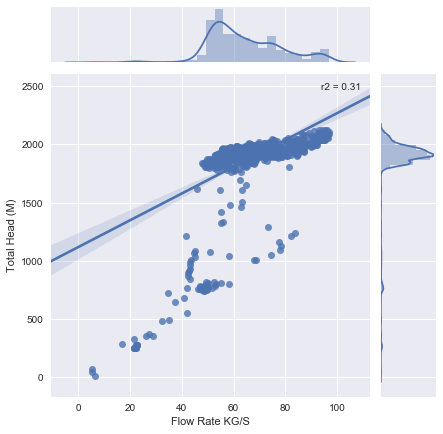

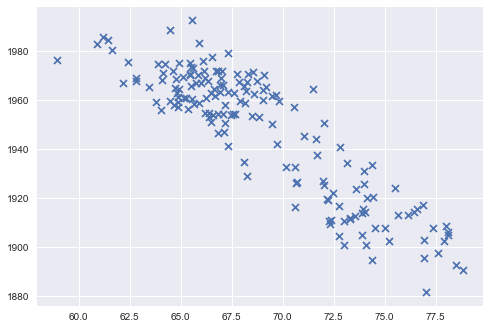

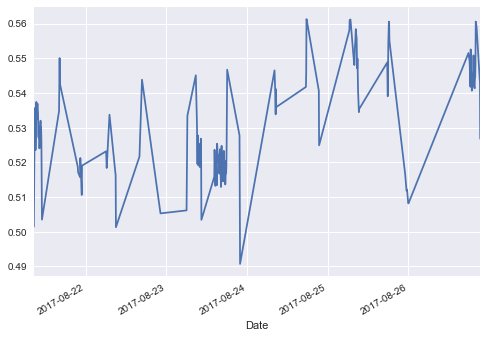

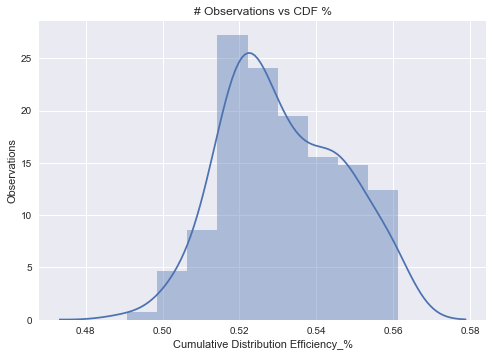

In [96]:
sbn.jointplot(df['Flow_Rate_(KG/S)'].values, df['Total Head'].values, kind="reg", stat_func=r2)
plt.xlabel('Flow Rate KG/S')
plt.ylabel('Total Head (M)')
plt.show()

#The scatter plot we have is different from what we expect. We can see from the above KDE plot that the majority of 
#RPM performance is ~90%. As such, we will not bother modelling the 25%,50% and 75% curves because the data does not 
#support the need for this. 
#We will now need to refilter the data so that only data in the "90%" range is captured.
#The filter cut off we will use will be +-0.05 therefore the range will be between >0.895 and < 0.905
#We will need to redefine df to accomodate for this. For the sake of simplicity, we will create a new df2 and store df
#in this.
df2 = df
df2 = df2[(df2['RPM_%']>0.895)& (df2['RPM_%']<0.905)]
plt.scatter(y=df2['Total Head'].values, x=df2['Flow_Rate_(KG/S)'].values, marker='x')
plt.show()
#fig = rshipPlot.savefig('rshipPlot.jpg')
#fig2 = distPlot.savefig('histogram.jpg')
#fig.savefig(...) 
df2['Efficiency_%'].plot()
plt.show()

distPlot = sbn.distplot(df2['Efficiency_%'].values, kde=True)
plt.xlabel('Cumulative Distribution Efficiency_%')
plt.ylabel('Observations')
plt.title("# Observations vs CDF %")
plt.show()


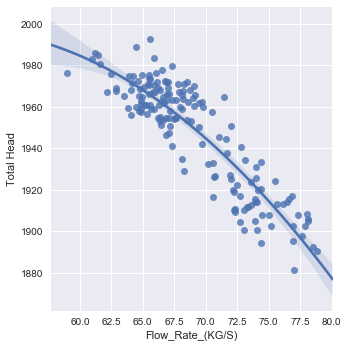

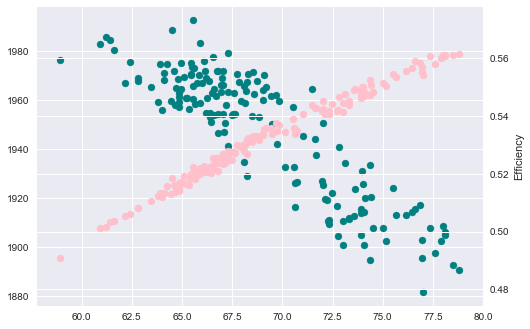

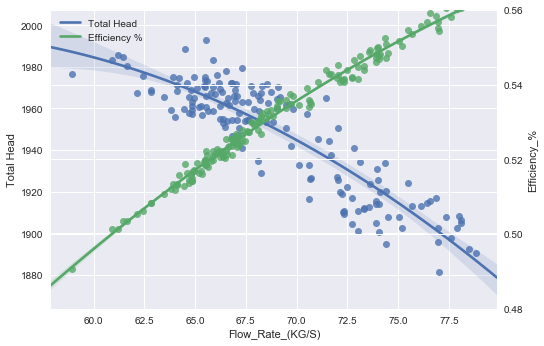

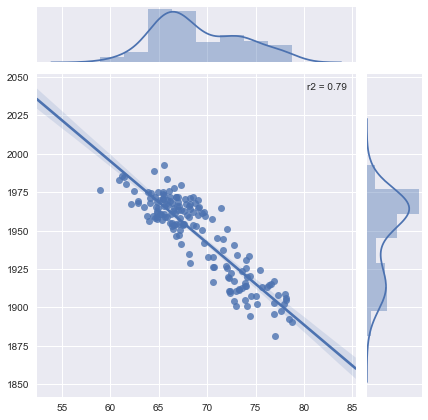

In [97]:
df3 = df2[['Flow_Rate_(KG/S)', 'Total Head']]
df4 = df2[['Flow_Rate_(KG/S)', 'Efficiency_%']]

sbn.lmplot(x="Flow_Rate_(KG/S)", y="Total Head", data=df3, order=2)
plt.show()
fig, ax = plt.subplots()

ax2 = ax.twinx()
ax.scatter(df2['Flow_Rate_(KG/S)'], df2['Total Head'], color='teal')
ax2.scatter(df2['Flow_Rate_(KG/S)'], df2['Efficiency_%'], color='pink')
ax2.set_ylabel('Efficiency')
plt.show()

fig, ax = plt.subplots()

ax2 = ax.twinx()


sbn.regplot(x="Flow_Rate_(KG/S)", y="Total Head", data=df3, order=2, ax=ax)
sbn.regplot(x="Flow_Rate_(KG/S)", y="Efficiency_%", data=df4, order=2, ax=ax2)
ax2.set_ylim([0.48, 0.56])
ax2.yaxis.set_major_locator(MultipleLocator(0.02))
ax2.legend(handles=[a.lines[0] for a in [ax,ax2]], labels=["Total Head", "Efficiency %"])
plt.show()


#sbn.lmplot(x="Flow_Rate_(KG/S)", y="Total Head", data=df3, order=2)
#sbn.lmplot(x="Flow_Rate_(KG/S)", y="Efficiency_%", data=df4, order=2)



sbn.jointplot(df3['Flow_Rate_(KG/S)'].values, df3['Total Head'].values, kind="reg", stat_func=r2)
plt.show()



0.490745118684
0.561301608466
